# Анализ покупок пользователей


## Постановка задачи

- Построить месячные и недельные когорты пользователей по этим данным. Выявить интересные наблюдения и закономерности.
- Какие еще инсайты можешь увидеть через эти данные?

## Описание данных:


| Поле               | Описание                        |
| :----------------  | :-------------------------------|
| `_id`              | id заказа                       |
| `user_id`          | id клиента                      |
| `total`            | сумма заказа после скидок       |
| `discount`         | скидка                          |
| `promo`            | промокод                        |
| `created_at`       | дата заказа                     |
| `location_id`      | код даркстора                   |

## Содержание:
- [EDA](#EDA)
- [Когортный анализ и Retention curve](#Когортный-анализ-и-Retention-curve)
- [В поисках инсайтов](#В-поисках-инсайтов)
- [Summary](#Summary)

<hr>

# EDA

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from operator import attrgetter
import datetime as dt

from scipy.stats import norm, shapiro, kruskal, mannwhitneyu
import pingouin as pg

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.2)

import matplotlib.pyplot as plt
import matplotlib. dates as mdates
%matplotlib inline

pd.set_option('display.max_column', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузим данные, посмотрим на их размерность и отобразим первые 5 строк
df = pd.read_csv('dataset.csv')
print(f'Размерность данных {df.shape}')
df.rename(columns={'_id': 'order_id', 'total': 'total_sum'}, inplace=True)
df.head()

,order_id,user_id,total_sum,discount,promo,created_at,location_id
0,611d0a77db6e75d74d1a2472,5d4bdf5d8d8735ab45d474e5d77ad708,12.053044,0.0,NaN,2021-08-18T13:26:15.793Z,60e9ad4c603cd8578de756f5
1,6120d7f9e53fb6b2b305974e,b3f004a5454487a3d9bb6f0e6efaaf4d,14.816226,14.0,YALLA476,2021-08-21T10:39:53.465Z,60e9ad4c603cd8578de756f5
2,612b709a6fd4c3dd8569b291,c376ec39984346ddaee5cbd07e284f64,49.710240,48.0,YALLA50,2021-08-29T11:33:46.702Z,60e9ad4c603cd8578de756f5
3,61291fd3db402abc11d18c3f,7a955ce61cc5fa3a4c6a2d49a0e3fd42,31.257000,30.0,YALLA476,2021-08-27T17:24:35.285Z,60e9ad4c603cd8578de756f5
4,611ce2ce33f3d291d52b91e1,54cfc68c71f40a14483f20bb4781fb9e,14.468320,0.0,NaN,2021-08-18T10:37:02.422Z,60e9ad4c603cd8578de756f5


Размерность данных (3807, 7)


In [3]:
# Посмотрим на типы данных в датафрейме
df.dtypes

order_id        object
user_id         object
total_sum      float64
discount       float64
promo           object
created_at      object
location_id     object
dtype: object

In [4]:
# Преобразуем колонку с датой к типу datetime
df['created_at'] = pd.to_datetime(df.created_at).dt.tz_localize(None)
df.head()

,order_id,user_id,total_sum,discount,promo,created_at,location_id
0,611d0a77db6e75d74d1a2472,5d4bdf5d8d8735ab45d474e5d77ad708,12.053044,0.0,NaN,2021-08-18 13:26:15.793,60e9ad4c603cd8578de756f5
1,6120d7f9e53fb6b2b305974e,b3f004a5454487a3d9bb6f0e6efaaf4d,14.816226,14.0,YALLA476,2021-08-21 10:39:53.465,60e9ad4c603cd8578de756f5
2,612b709a6fd4c3dd8569b291,c376ec39984346ddaee5cbd07e284f64,49.710240,48.0,YALLA50,2021-08-29 11:33:46.702,60e9ad4c603cd8578de756f5
3,61291fd3db402abc11d18c3f,7a955ce61cc5fa3a4c6a2d49a0e3fd42,31.257000,30.0,YALLA476,2021-08-27 17:24:35.285,60e9ad4c603cd8578de756f5
4,611ce2ce33f3d291d52b91e1,54cfc68c71f40a14483f20bb4781fb9e,14.468320,0.0,NaN,2021-08-18 10:37:02.422,60e9ad4c603cd8578de756f5


In [5]:
# Посмотрим есть ли пропущенные значения в данных
missing = df.isna().sum()
missing[missing > 0]

promo    2164
dtype: int64

Поле `promo` содержит 2164 отсутствующих значений. Попробуем разобраться с чем это связано. Предположим, что не у всех пользователей, которые совершают покупку есть промокод, соответственно скидка им не предоставляется.

In [6]:
# Посмотрим на размер скидки пользователей у которых нет промокода
df[df.promo.isnull()].discount.describe().reset_index().T

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
discount,2164,0,0,0,0,0,0,0


Таким образом, отсутствие значений по промокуду  может объясняется тем что не всех пользователей есть промокод. В таком случае скидка не предоставляется.

In [7]:
# Посмотрим есть ли дубликаты строк в датафрейме
df.duplicated().sum()

0

In [8]:
# Посмотрим на описательную статистику по категориальным переменным
df.describe(include=['O']).T

,count,unique,top,freq
order_id,3807,3807,61475cc14f4df17981bd586c,1
user_id,3807,1109,f7c6507d693a6ad60b79f7933f8449da,74
promo,1643,287,TEAM,199
location_id,3807,2,60e9ad4c603cd8578de756f5,3716


- Пользователь с id `f7c6507d693a6ad60b79f7933f8449da` встречается 74 раза в датасете;
- 287 уникальных промокода, из них чаще всего используется `TEAM`;
- Количество уникальных дарксторов - 2, большая часть пользователей из даркстора `60e9ad4c603cd8578de756f5`.

In [9]:
# Посмотрим на уникальные значения промокодов (отобразим первые 50 значений)
df.promo.unique()[:50]

array([nan, 'YALLA476', 'YALLA50', 'SORRY', 'YALLA146', 'YALLA!',
       'NOOR30', 'YALLA187', 'YALLA60', 'MBYALLA', 'Yalla146', 'YALLA791',
       'YALLA971TEAM', 'Shahi150', 'TEAM', 'LUCI50', 'BD35', 'TT175',
       'A4A438', 'JLT35', 'YALLA40', 'MBYALLA25', 'BACK', 'MOTB50', 'BAG',
       'PRITI150', 'YALLA30', 'THX30', 'HELLO50', 'mbyalla', 'SUPTHX30',
       'bag', 'yalla50', 'DFL50', 'SACHI50', 'yalla', 'YALLAJLT', 'JP50',
       'CAE', 'sorry', 'SORRY536', '93E9E0', 'YALLA', 'AKSA200', 'SSS200',
       'yalla40', 'V200', 'WELCOME50', 'HELLOYALLA', 'NOV'], dtype=object)

Названия промокодов встречаются как в верхнем, так и нижнем регистре - поработаем с этим полем.

In [10]:
df['promo'] = df.promo.str.lower()
df['promo'] = df.promo.str.replace('!', '')
df['promo'] = df.promo.str.replace('nov', 'now')
df.promo.nunique()

230

После небольших преобразований количество уникальных значений в поле `promo` снизилось до 230. Возможно, в оставшемся перечне промокодов есть еще идентичные значения, которые записаны по разному.

In [11]:
# Посмотрим на топ 10 самых частых промокодов
df.promo.value_counts() \
    .reset_index() \
    .rename(columns={'index': 'promo', 'promo': 'number'}) \
    .sort_values('number', ascending=False)[:10]

,promo,number
0,team,200
1,mbyalla,136
2,yalla,120
3,bag,104
4,yallajlt,91
5,yalla50,86
6,sorry,63
7,cae,42
8,yalla476,35
9,jlt35,29


**Посмотрим по какому префиксу больше всего промокодов.**

In [12]:
# Произведем необходимые преобразования
df['promo_key'] = df.promo.str.extract('([a-z]+)')
df['promo_key'] = df.promo_key.str.replace('mbyalla', 'yalla')
df['promo_key'] = df.promo_key.str.replace('yallajlt', 'yalla')

# Посмотрим на топ 5 
top_promo = df.promo_key.value_counts()[:5].reset_index().rename(columns={'index': 'promo_key', 'promo_key': 'count'})
top_promo

,promo_key,count
0,yalla,604
1,team,200
2,bag,110
3,sorry,81
4,cae,42


Чаще всего встречаются промокоды содержащие слово `yalla`.

In [13]:
# Посмотрим какой процент в выборке по дарксторам
df.location_id.value_counts(normalize=True) \
    .round(2).reset_index() \
    .rename(columns={'index': 'location_id', 'location_id': 'percentage'})

,location_id,percentage
0,60e9ad4c603cd8578de756f5,0.98
1,610bea24116a2e35936f3871,0.02


In [14]:
# Посмотрим на описательную статистику по количественным переменным
df.describe(percentiles=[0, 1/6, 1/3, .5, 2/3, 5/6, 1]).T.round(3)

,count,mean,std,min,0%,16.7%,33.3%,50%,66.7%,83.3%,100%,max
total_sum,3807.0,28.083,42.499,0.033,0.033,4.244,8.216,13.25,24.071,50.127,706.218,706.218
discount,3807.0,19.062,48.028,0.000,0.000,0.000,0.000,0.00,3.945,35.339,705.000,705.000


- Сумма 80% заказов не превышает 50 ден. единиц;
- Максимальная скидка 705. В большинстве случаев, скидка указывается в %. Поскольку в описании данных ничего не сказано, что из себя представляет скидка (процент или размер скидки выраженный в ден. единицах) возникает вопрос - может ли это означать, что в данном поле имеются ошибки в данных или аномалии?

### Посмотрим на распределение скидки

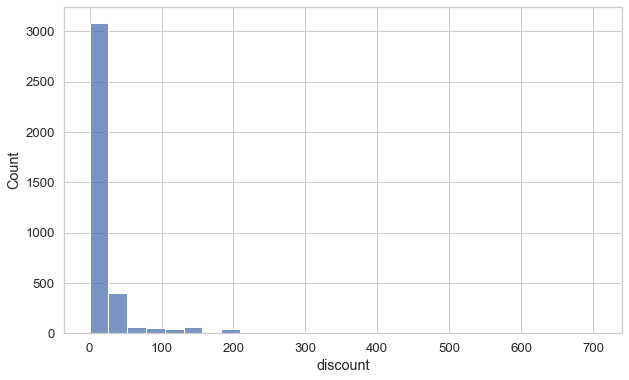

In [15]:
plt.figure(figsize=(10, 6))
bins = round(1 + 3.2 * np.log(df.discount.shape[0]))
sns.histplot(df.discount, bins=bins);

**Анализ гистограммы позволяет сделать предположение, что скидка указана не в % - в данном поле указана сумма скидки.**

In [16]:
# Посмотрим на данные со скидкой свыше 350
df[df.discount > 350]

,order_id,user_id,total_sum,discount,promo,created_at,location_id,promo_key
487,617d1cea0ad8a1a7f35f3372,16bd07616c1102486f054c4d98984705,423.987466,423.987466,sorry,2021-10-30 10:22:34.680,60e9ad4c603cd8578de756f5,sorry
1054,615ae1c32b2492d9211321c4,d10cf5042dd91b6ef1c834cebeba5949,368.179912,368.179912,mbyalla,2021-10-04 11:13:06.610,60e9ad4c603cd8578de756f5,yalla
1359,615d52982b2492d921132208,9641b170d41cd31b8d295747ddfccba4,508.944896,508.944896,mbyalla,2021-10-06 07:39:04.460,60e9ad4c603cd8578de756f5,yalla
1477,6197e748a6359ac06b88a40b,8f30808d35c78b1f1aea3fb51274de5a,5.520000,400.000000,shera400,2021-11-19 18:04:56.175,610bea24116a2e35936f3871,shera
1629,615e8bc9667ddd54e2291287,33cf0ebdce0b93724721a02576ded7cd,387.019858,387.019858,yallajlt,2021-10-07 05:55:21.211,60e9ad4c603cd8578de756f5,yalla
2655,611f8a7bdb6e75d74d1a24d5,0e3a17b22a6e1ffb3d9eeb3a232b9ec3,706.217577,705.000000,yalla,2021-08-20 10:56:59.245,60e9ad4c603cd8578de756f5,yalla


**Интересное наблюдение** - по некоторым промокодам скидка равна сумме заказа после скидки.<br>
Посмотрим сколько у нас всего таких наблюдений.

In [17]:
df[df.total_sum == df.discount].shape[0]

213

In [18]:
# Посмотрим по каким промокодам есть совпадение суммы заказа после скидок и скидки
df[df.total_sum == df.discount] \
    .promo.value_counts() \
    .reset_index() \
    .rename(columns={'index': 'promo', 'promo': 'count'}) \
    .sort_values('count', ascending=False)

,promo,count
0,mbyalla,72
1,yallajlt,60
2,sorry,39
3,helloyalla50,12
4,myyalla,9
5,helloyalla,6
6,myyalla50,6
7,uro50,3
8,back,2
9,b50,2


Таким образом у нас 213 наблюдений у которых сумма заказа после скидок равна скидке. Для того чтобы понимать являются ли валидными такие наблюдения необходима дополнительная информация.

### Посмотрим на распределение суммы заказа после скидок

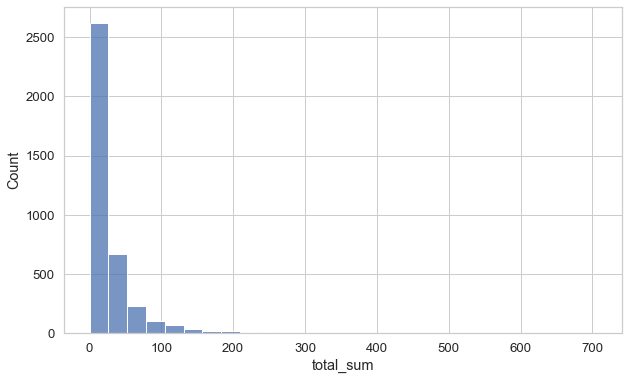

In [19]:
plt.figure(figsize=(10, 6))
bins = round(1 + 3.2 * np.log(df.total_sum.shape[0]))
ax = sns.histplot(df.total_sum, bins=bins);

### Посмотрим на распределение суммы заказа после скидок в зависимости от наличия скидки

In [20]:
# Создадим дополнительный столбец где будет указано наличие скидки
df['has_discount'] = np.where(df.discount > 0, 'yes', 'no')

# Прологорифмируем total_sum
df['log_total'] = np.log(df.total_sum)

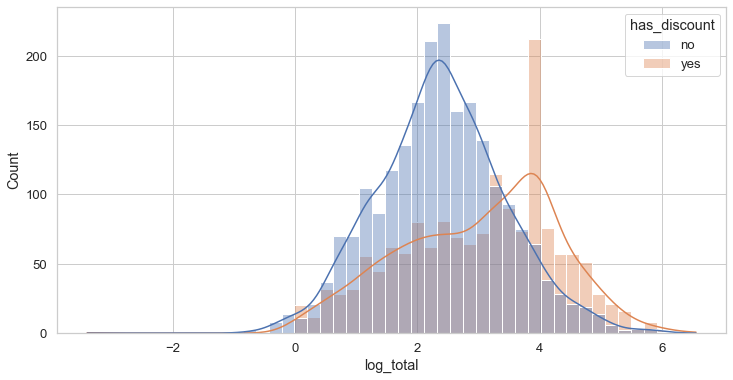

In [21]:
# Визуализируем данные
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='log_total', hue='has_discount', alpha=0.4, kde=True);

### Посмотрим на средние значения суммы заказа после скидок в зависимости от наличия скидки

In [22]:
discount_df = df.groupby('has_discount', as_index=False) \
    .agg(total_mean=('total_sum', 'mean'),
         total_median=('total_sum', 'median'),
         size=('user_id', 'count')) \
    .round(2)

discount_df

,has_discount,total_mean,total_median,size
0,no,19.34,10.73,2220
1,yes,40.31,24.78,1587


**Сформулируем гипотезы для проверки:**

- **Нулевая гипотеза** $(H_0)$: Разницы между средними значениями в двух группах нет
- **Альтернативная гипотеза** $(H_1)$: Разница между средними значениями суммы заказов в двух группах есть

In [23]:
# Проверим выполнение условий на нормальность с помощью теста Шапиро-Уилка
for col in df.has_discount.unique().tolist():
    data_sample = df[df.has_discount == col].log_total.sample(500, random_state=17)
    print(f'{col} - pvalue: {shapiro(data_sample)[1]:.4f}')

no - pvalue: 0.6370
yes - pvalue: 0.0000


In [24]:
# Используем функцию normality
pg.normality(data=df, dv='log_total', group='has_discount', method='normaltest')

,W,pval,normal
no,7.753638,2.071662e-02,False
yes,34.883506,2.661601e-08,False


Таким образом, результаты теста на нормальность позволяют сделать следующие выводы:
- Распределение логарифма суммы заказов при отсутствии скидки не является нормальным
- Распределение логарифма суммы заказов при наличии скидки не является нормальным

Поскольку распределения в двух выборках отличаются от нормального воспользуемся непараметрическим критерием Манна-Уитни и бутстрапом.

In [25]:
# Создадим переменные с значениями по двум группам
no_group = df[df.has_discount == 'no'].total_sum
yes_group = df[df.has_discount == 'yes'].total_sum

In [26]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(data_col_1, data_col_2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    boot_len = max([len(data_col_1), len(data_col_2)])
    boot_data = []
    for i in range(boot_it):
        sample_1 = data_col_1.sample(boot_len, replace=True).values
        sample_2 = data_col_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(sample_1 - sample_2))
        
        pd_boot_data = pd.DataFrame(boot_data)
        
        p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
        p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
        p_value = min(p_1, p_2) * 2
        
    return {"p-value": p_value}

In [27]:
# Посмотрим на значение p-value бустрапа для средних значений и критерия Манна-Уитни
res_mw = mannwhitneyu(no_group, yes_group, alternative='two-sided')
res_boot_mean = get_bootstrap(no_group, yes_group)
res_boot_median = get_bootstrap(no_group, yes_group, statistic=np.median)
print(f'Boot mean: {res_boot_mean["p-value"]:.3}; Boot median: {res_boot_median["p-value"]:.3}: MW: {res_mw.pvalue:.3}')

Boot mean: 1.5e-59; Boot median: 1.09e-25: MW: 1.92e-57


Сравнение средних и медианных значений в двух группах с помощью бутстрап позволяет сделать вывод о том что различие статистически значимо ($p < 0.05$), т.е. позволяет отклонить нулевую гипотезу о равенстве средних значений. Значение p-value критерия Манна-Уитни $p < 0.05$ говорит о том, различие исследуемых выборок статистически значимо.

**Таким образом, в исследуемой выборке средняя сумма заказа при наличии скидки выше чем средняя сумма заказа без скидки.**

<hr>

# Когортный анализ и Retention curve

In [28]:
# Объявим функцию для построения когортного анализа
def cohort_analysis(data, ids_col, target_col, period='M'):
    """Функция для построения когортного анализа.
    Рассчитывает коэффициент удержания клиентов (Retention Rate) и
    возвращает матрицу когорт с временным интервалом. 
    
    Параметры
    ---------
    data: pandas DataFrame
        Датасет
    ids_col: str
        Поле с id клиентов/пользователей. Тип данных: object, int64
    target_col: str
        Поле с датой покупки/регистрации и т.п. Тип данных datetime64[ns]
    period: str
        Поле с указание периода когорты: 'M' - месяц, 'W' - неделя.
        Дефолтное значение 'M'. Тип данных str
    """
    # создается промежуточный датасет, чтобы не изменять изначальный датасет
    df = data[[ids_col]]
    
    # создается дополнительный столбец с периодом целевого действия
    df['order_period'] = data[target_col].dt.to_period(period)
    
    # формируется когорта с наименьшей датой совершения целевого действия пользователем
    df['cohort'] = data.groupby(ids_col)[target_col].transform('min').dt.to_period(period)
    
    # рассчитывается количество уникальных пользователей в каждой группе
    df_cohort = df.groupby(['cohort', 'order_period'], as_index=False).agg(n_customers=(ids_col, 'nunique'))
    
    # рассчитывается период между когортой и периодом совершения целевого действия
    df_cohort['period_number'] = (df_cohort.order_period - df_cohort.cohort).apply(attrgetter('n'))
    
    # создается сводная таблица по рассчитанным показателям
    cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')
    
    # переменная с размером когорты
    cohort_size = cohort_pivot.iloc[:, 0]
    
    # рассчитывается коэффициент удержания клиентов
    matrix = cohort_pivot.divide(cohort_size, axis = 0)
     
    # задает цветовое форматирование и заголовок
    retention_matrix = (matrix
            .style
            .set_caption('Коэффициент удержания клиентов по кагортам')
            .background_gradient(cmap='viridis')
            .highlight_null('white')
            .format("{:.2%}", na_rep=''))
    
    return retention_matrix

In [29]:
# Строим когортный анализ для наших данных по месяцам
cohort_analysis(df, 'user_id', 'created_at')

period_number,0,1,2,3
cohort,,,,
2021-08,100.00%,38.32%,20.36%,18.56%
2021-09,100.00%,35.64%,21.45%,
2021-10,100.00%,40.13%,,
2021-11,100.00%,,,


### Выводы

**Из итоговой матрицы видно, что в последующие месяцы после первой покупки, происходит снижение повторных покупок клиентами. При этом заметен рост числа повторных покупок пользователями из когорты 2021-10 г.**

In [30]:
# Строим когортный анализ для наших данных по неделям
cohort_analysis(df, 'user_id', 'created_at', period='W')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cohort,,,,,,,,,,,,,,,,
2021-08-16/2021-08-22,100.00%,26.98%,30.16%,22.22%,19.05%,25.40%,17.46%,20.63%,14.29%,11.11%,3.17%,11.11%,7.94%,11.11%,9.52%,1.59%
2021-08-23/2021-08-29,100.00%,13.58%,9.88%,11.11%,12.35%,8.64%,6.17%,4.94%,8.64%,3.70%,9.88%,6.17%,3.70%,6.17%,3.70%,
2021-08-30/2021-09-05,100.00%,21.13%,19.72%,19.72%,5.63%,8.45%,15.49%,5.63%,9.86%,7.04%,7.04%,8.45%,7.04%,2.82%,,
2021-09-06/2021-09-12,100.00%,24.69%,17.28%,23.46%,16.05%,13.58%,17.28%,18.52%,11.11%,11.11%,13.58%,9.88%,3.70%,,,
2021-09-13/2021-09-19,100.00%,17.50%,12.50%,27.50%,13.75%,22.50%,18.75%,15.00%,17.50%,12.50%,17.50%,5.00%,,,,
2021-09-20/2021-09-26,100.00%,11.11%,3.70%,5.56%,16.67%,3.70%,3.70%,3.70%,7.41%,1.85%,,,,,,
2021-09-27/2021-10-03,100.00%,32.43%,22.97%,21.62%,22.97%,20.27%,21.62%,17.57%,20.27%,6.76%,,,,,,
2021-10-04/2021-10-10,100.00%,25.71%,18.57%,21.43%,27.14%,18.57%,21.43%,18.57%,7.14%,,,,,,,
2021-10-11/2021-10-17,100.00%,23.19%,28.99%,27.54%,24.64%,17.39%,21.74%,5.80%,,,,,,,,


### Выводы

- **Анализ недельных когорт позволяет выявить определенную сезонность - через некоторый период происходит незначительное увеличение повторных покупок пользователями;**
- **Пользователи пришедшие с 2021-09-20 по 2021-09-26 совершали наименьшее количество повторных покупок за анализируемый период;**
- **У пользователей пришедших в период с 2021-09-27 по 2021-11-01 наблюдается увеличение числа повторных покупок по сравнению с другими когортами.**

In [31]:
# Объявим функцию для построения кривой Retention
def plot_retention_curve(data, ids_col, target_col, period='M'):
    """Функция для построения кривой коэффициента удержания пользователей.
    Рассчитывает коэффициент удержания клиентов (Retention Rate) и
    строит график отображающий изменение retention по когортам во времени. 
    
    Параметры
    ---------
    data: pandas DataFrame
        Датасет
    ids_col: str
        Поле с id клиентов/пользователей. Тип данных: object, int64
    target_col: str
        Поле с датой покупки/регистрации и т.п. Тип данных datetime64[ns]
    period: str
        Поле с указание периода когорты: 'M' - месяц, 'W' - неделя.
        Дефолтное значение 'M'. Тип данных str
    """
    # создается промежуточный датасет, чтобы не изменять изначальный датасет
    df = data[[ids_col]]
    
    # создается дополнительный столбец с периодом целевого действия
    df['order_period'] = data[target_col].dt.to_period(period)
    
    # формируется когорта с наименьшей датой совершения целевого действия пользователем
    df['cohort'] = data.groupby(ids_col)[target_col].transform('min').dt.to_period(period)
    
    # рассчитывается количество уникальных пользователей в каждой группе
    df_cohort = df.groupby(['cohort', 'order_period'], as_index=False).agg(n_customers=(ids_col, 'nunique'))
    
    # рассчитывается период между когортой и периодом совершения целевого действия
    df_cohort['period_number'] = (df_cohort.order_period - df_cohort.cohort).apply(attrgetter('n'))
    
    # объединяем когорты по заданному интервалу и считаем количество пользователей
    retention_df = df_cohort.groupby('period_number', as_index=False).agg(n_users=('n_customers', 'sum'))
    
    # рассчитываем коэффициент удержания пользователей
    retention_df['retention'] = (retention_df.n_users / retention_df.head(1).n_users.values[0])
    
    # строим график
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(data=retention_df, x='period_number', y='retention', linewidth = 3)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticks(np.arange(retention_df.period_number.min(), retention_df.period_number.max()+1, 1))
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    
    if period == 'M':
        x_label = 'Month'
    if period == 'W':
        x_label = 'Week'
    
    ax.set(title = 'Retention curve',
           xlabel = x_label, 
           ylabel = '% of users retained')
    plt.show();

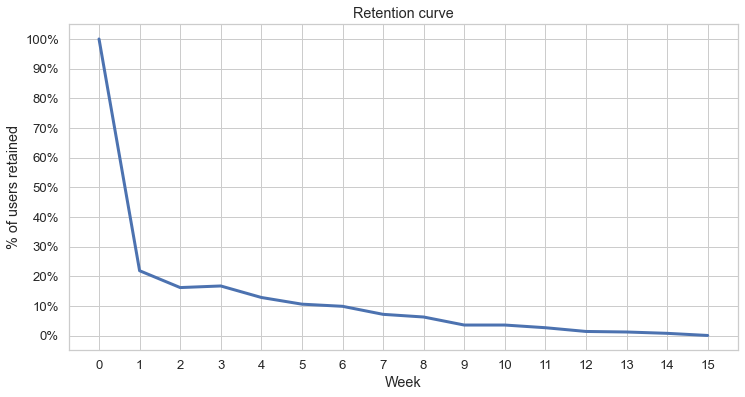

In [32]:
# Визуализируем retention curve
plot_retention_curve(df, 'user_id', 'created_at', period='W')

### Выводы

- **Oколо 78% пользователей не делают повторных покупок после 1-й недели.**
- **После 4-й недели происходит плавное снижение числа повторных покупок.**
- **Пользователи практически полностью прекращают делать повторные покупки на 16-ю неделю.**

<hr>

# В поисках инсайтов

### Посмотрим сколько у нас пользователей совершили покупку только один раз

In [33]:
# Добавим дополнительный столбец с частотой покупок
df['frequency'] = np.where(df.groupby('user_id').order_id.transform('count') > 1, 'several', 'once')

# Посчитаем количество пользователей
frequency = df.groupby('frequency', as_index=False).agg(users_number=('user_id', 'nunique'))
frequency['percentage'] = (frequency.users_number / frequency.users_number.sum()).mul(100).round(2)
frequency

,frequency,users_number,percentage
0,once,588,53.02
1,several,521,46.98


**Таким образом, 53% пользователей совершили покупку только один раз.**

<hr>

### Посмотрим различаются ли средние суммы покупок в зависимости от частоты покупок

In [34]:
# Посчитаем средние значения по группам
df.groupby('frequency', as_index=False) \
    .agg(mean_sum=('total_sum', 'mean'),
         median_sum=('total_sum', 'median'))

,frequency,mean_sum,median_sum
0,once,40.158539,18.249718
1,several,25.876926,12.520000


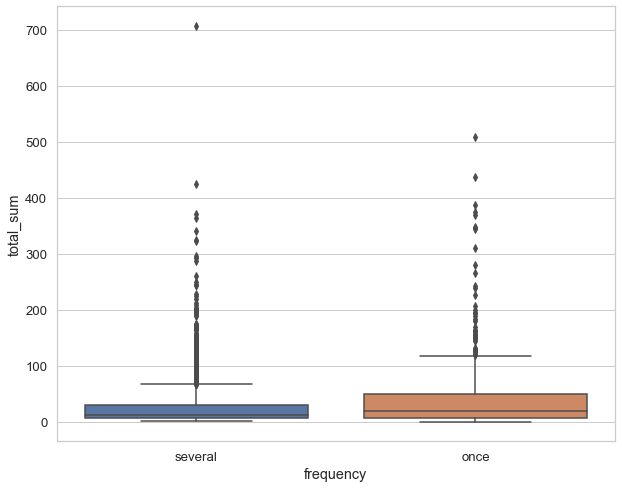

In [35]:
# Посмотрим на распределения на графике
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='frequency', y='total_sum');

Из графика видно, что в двух группах имеются выбросы, которые смещаю среднее значение в выборках.<br>

**Сформулируем гипотезы для проверки:**

- **Нулевая гипотеза** $(H_0)$: Разницы между средними значениями суммы заказа пользователей с одной покупкой и пользователей с несколькими покупками нет 
- **Альтернативная гипотеза** $(H_1)$: Разница между средними значениями суммы заказов в двух группах есть

In [36]:
# Создадим переменные с значениями по двум группам
once_group = df[df.frequency == 'once'].total_sum
several_group = df[df.frequency == 'several'].total_sum

# Посмотрим на значение p-value бустрапа для средних значений и критерия Манна-Уитни
res_mw = mannwhitneyu(once_group, several_group, alternative='two-sided')
res_boot_mean = get_bootstrap(once_group, several_group)
res_boot_median = get_bootstrap(once_group, several_group, statistic=np.median)
print(f'Boot mean: {res_boot_mean["p-value"]:.3}; Boot median: {res_boot_median["p-value"]:.3}: MW: {res_mw.pvalue:.3}')

Boot mean: 1.74e-28; Boot median: 1.24e-07: MW: 1.7e-05


Сравнение средних и медианных значений в двух группах с помощью бутстрап позволяет сделать вывод о том что различие статистически значимо ($p < 0.05$), т.е. позволяет отклонить нулевую гипотезу о равенстве средних значений. Значение p-value критерия Манна-Уитни $p < 0.05$ говорит о том, различие исследуемых выборок статистически значимо.

**Таким образом, в исследуемой выборке средняя сумма заказа пользователей с одной покупкой в среднем выше чем средняя покупка пользователь с несколькими покупками.**

<br>

### Посмотрим различаются ли средние суммы заказов в зависимости от частоты и наличия скидки

In [37]:
df.pivot_table(index='frequency', columns='has_discount', values='total_sum', aggfunc=['mean', 'median']).round(2)

mean        median       
has_discount     no    yes     no    yes
frequency                               
once          24.17  51.42   12.0  32.94
several       18.75  37.22   10.6  22.80

При наличии скидки (промокода) средняя сумма заказа выше как для пользователей которые совершили одну покупку, так и для пользователей которые совершили несколько покупок.

<hr>

### Посмотрим различаются ли средние суммы заказов в зависимости от частоты и размера скидки

In [38]:
# Зададим интервалы скидок
df['discount_bins'] = pd.cut(df['discount'],
                             bins=[0, 10, 20, 50, 100, 200, 300, 750],
                             labels=['0-10', '10-20', '20-50', '50-100', '100-200', '200-300', 'above 300'])

# Сделаем сводную таблицу
df[df.has_discount == 'yes'] \
    .pivot_table(index='discount_bins', columns='frequency', values='total_sum', aggfunc=['mean', 'median']) \
    .round(2) \
    .style \
    .background_gradient(cmap='viridis') \
    .format('{:.5}')

**Для пользователей, совершивших несколько покупок, с увеличением скидки увеличивается средняя сумма заказа после скидок.**

<hr>

### Посмотрим в какой день совершается больше всего покупок

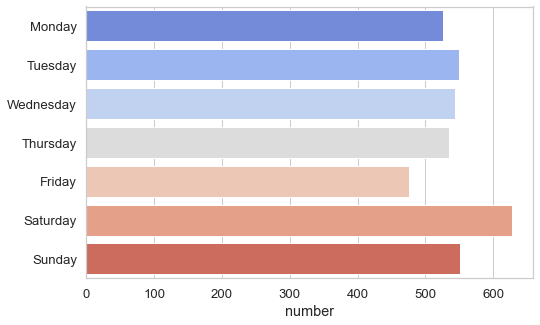

In [39]:
perchases_by_days = df.created_at.dt.day_name() \
    .value_counts() \
    .reset_index() \
    .rename(columns={'index': 'purchase_day', 'created_at': 'number'})

plt.figure(figsize=(8, 5))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.barplot(x='number', y='purchase_day', data=perchases_by_days, palette = 'coolwarm', order=order, orient='h')
ax.set(ylabel='');

**Таким образом, больше всего покупок осуществляется в субботу.**

<hr>

### Посмотрим на изменение общей суммы заказов по дням

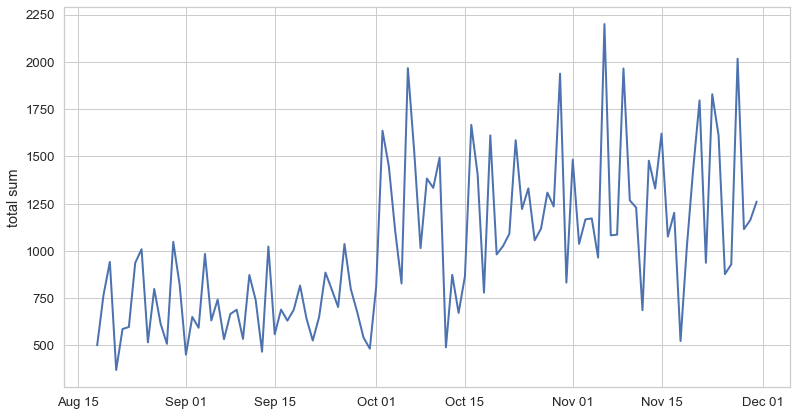

In [40]:
# Агрегируем данные по дням и посчитаем общую сумму заказов
days_total = df.set_index('created_at').total_sum.resample(rule='1d').sum()

# Визуализируем результат
plt.figure(figsize=(13, 7))
ax = sns.lineplot(data=days_total, linewidth = 2)
ax.set(xlabel = '', ylabel = 'total sum')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

Из графика видно, что присутствует высокая изменчивость, при этом в октябре произошло увеличение общей суммы заказов которое сопровождается еще большей изменчивостью. Для того чтобы увидеть тренды воспользуемся скользящим средним.

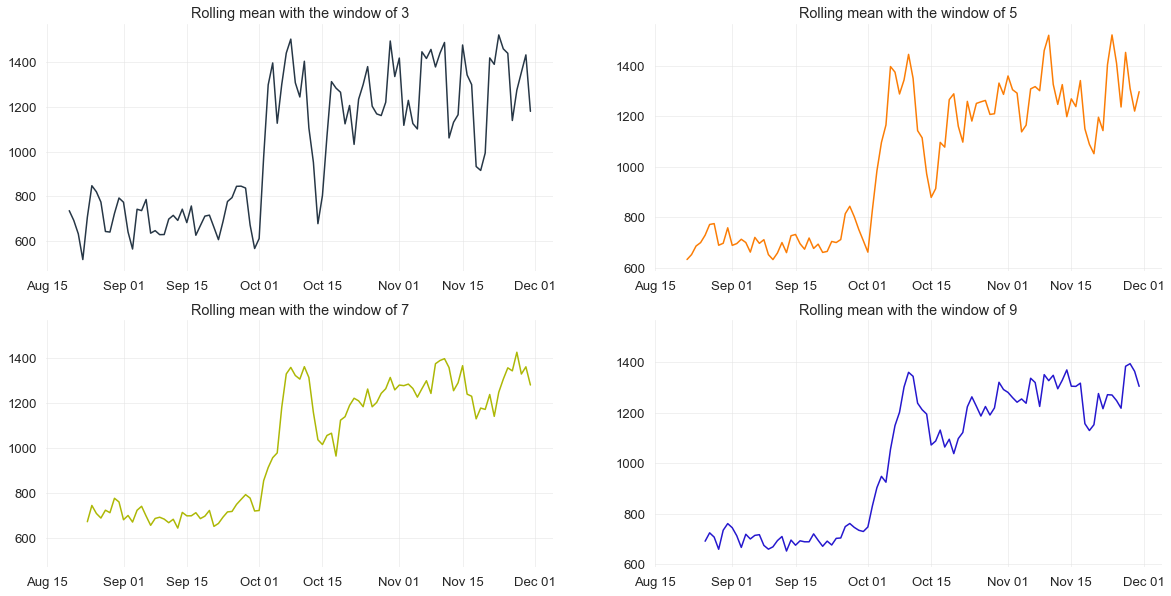

In [41]:
# Зададим параметры для размера окна скользящего среднего
windows = [3, 5, 7, 9]
colors = ['#273746', '#FB7D06', '#ADB806', '#2618CE']

# Сделаем расчеты и визуализируем результат
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharey='col', sharex=True)
for window, ax, color in zip(windows, axes.flatten(), colors):
    ax.plot(days_total.rolling(window=window).mean(), label=window, color=color)

for ax in axes.flatten():
    ax.set_frame_on(False)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.grid(True, color='#e2e2e2', alpha=0.5)
    sns.despine()
    
for name, ax in zip(['3' , '5' , '7', '9'] , axes.flatten()):
    ax.set(title='Rolling mean with the window of {}'.format(name))
    ax.tick_params(labelbottom=True, which='both')

**Анализ графиков показывает, что в анализируемом периоде наблюдается положительный тренд в изменении общей суммы заказов по дням. При этом существенное увеличение общей суммы заказов произошло в начале октября.**

<hr>

### Посмотрим на изменение средней суммы заказов по дням и на количество пользователей

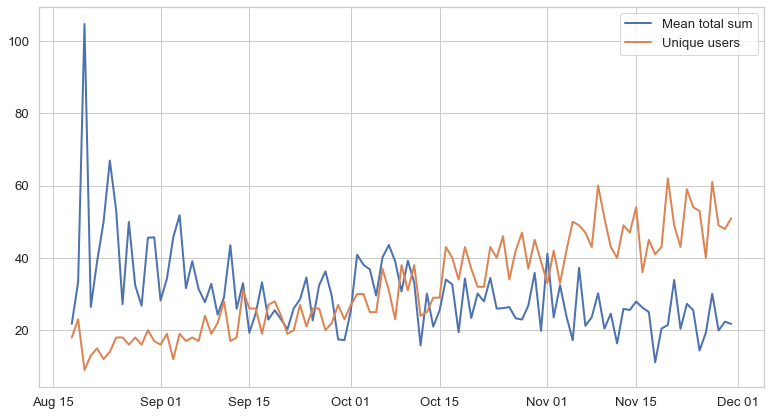

In [42]:
# Агрегируем данные по дням и посчитаем среднее значение суммы заказов по дням
days_mean = df.set_index('created_at').total_sum.resample(rule='1d').mean()

# Агрегируем данные по дням и посчитаем количество уникальных пользователей по дням
days_visits = df.set_index('created_at').user_id.resample(rule='1d').nunique()

# Визуализируем результат
plt.figure(figsize=(13, 7))
ax = sns.lineplot(data=days_mean, linewidth = 2)
ax = sns.lineplot(data=days_visits, linewidth = 2)
ax.set(xlabel = '', ylabel = '')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.legend(labels=['Mean total sum', 'Unique users']);

Из графика видно, что присутствует высокая изменчивость как в средней сумме заказов по дням, так и количестве уникальных пользователей по дням. При этом прослеживается некоторый тренд - с ростом количества пользователей происходит снижение средней суммы заказов. Для того чтобы увидеть эти тренды более отчетливо воспользуемся скользящим средним с размером окна 5.

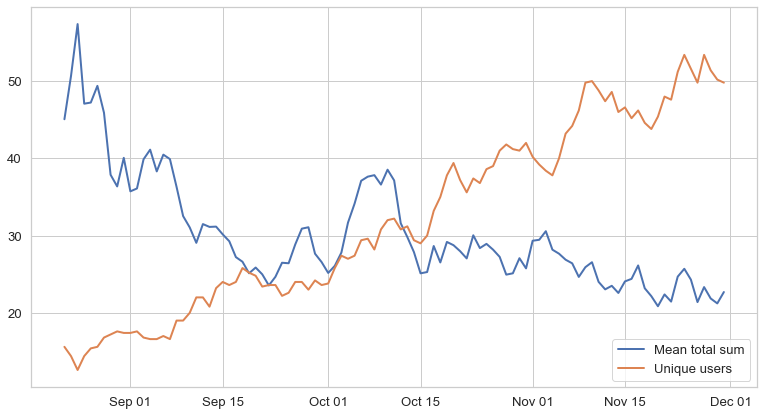

In [43]:
# Рассчитаем скользящее среднее для средней суммы заказов по дням
rolling_sum = days_mean.rolling(window=5).mean()

# Рассчитаем скользящее среднее для количества уникальных пользователей по дням
rolling_visits = days_visits.rolling(window=5).mean()

# Визуализируем результат
plt.figure(figsize=(13, 7))
ax = sns.lineplot(data=rolling_sum, linewidth = 2)
ax = sns.lineplot(data=rolling_visits, linewidth = 2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set(xlabel = '', ylabel = '')
plt.legend(labels=['Mean total sum', 'Unique users']);

- **В период с сентября по декабрь происходит снижение средней суммы заказов;**
- **В период с сентября по декабрь происходит рост количества уникальных пользователей.**

<hr>

### Посмотрим на динамику средней суммы заказа пользователя по неделям и построим доверительный интервал

In [44]:
# Создадим дополнительный столбец с периодом по неделям
df['week_period'] = df['created_at'].dt.to_period('W')

# Посчитаем среднюю сумму заказа по месяцам и количество пользователей
week_purchases = df.groupby(['week_period']) \
                    .agg(arpu=('total_sum', 'mean'),
                         count=('user_id', 'nunique'),
                         sd=('total_sum', 'std'))

week_purchases.head()

,arpu,count,sd
week_period,,,
2021-08-16/2021-08-22,37.695688,63,81.719642
2021-08-23/2021-08-29,42.226586,98,53.192879
2021-08-30/2021-09-05,40.493490,101,53.544426
2021-09-06/2021-09-12,31.850942,118,31.843600
2021-09-13/2021-09-19,26.071232,135,27.077699


Воспользуемся формулой для строительства доверительного интервала для среднего:
$$
\hat \mu \pm z_{1 - \frac{\alpha}{2}} \cdot \frac{sd} {\sqrt{n}} 
$$

In [45]:
# Зададим уревень значимости
alpha = 0.05

# Рассчитаем границы интервалов
q = norm.ppf(1 - alpha/2)
week_purchases['left'] = week_purchases['arpu'] - q * week_purchases['sd']/np.sqrt(week_purchases['count'])
week_purchases['right'] = week_purchases['arpu'] + q * week_purchases['sd']/np.sqrt(week_purchases['count'])

week_purchases.head()

,arpu,count,sd,left,right
week_period,,,,,
2021-08-16/2021-08-22,37.695688,63,81.719642,17.516472,57.874903
2021-08-23/2021-08-29,42.226586,98,53.192879,31.695127,52.758045
2021-08-30/2021-09-05,40.493490,101,53.544426,30.051058,50.935922
2021-09-06/2021-09-12,31.850942,118,31.843600,26.105423,37.596460
2021-09-13/2021-09-19,26.071232,135,27.077699,21.503581,30.638884


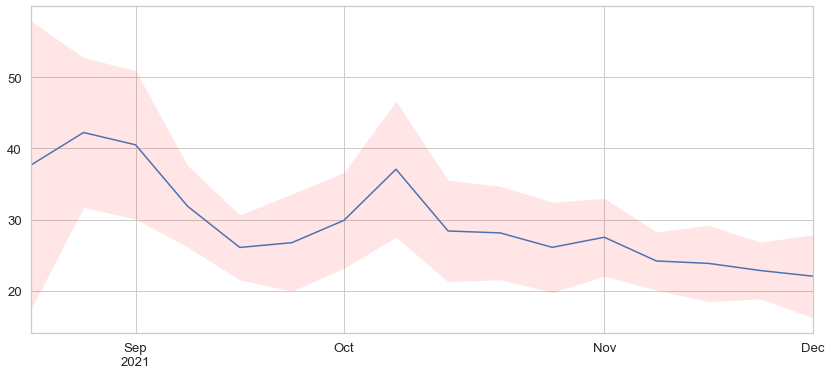

In [46]:
# Визуализируем результат
ax = week_purchases['arpu'].plot(figsize=(14, 6))
plt.fill_between(week_purchases.index, week_purchases['left'], week_purchases['right'], 
                 facecolor='red', alpha=0.1, interpolate=True)

ax.set(xlabel = '');

**Таким образом, в анализируемом периоде средняя сумма заказа пользователя в неделю снижается. Широкий 95% доверительный интервал в начале анализируемого периода может объясняется тем, что имеются данные только за половину августа.**

<hr>

# Summary

## Выводы по когортному анализу


### Месячные когорты:
- Анализ месячных когорт показывает, что в последующие месяцы после первой покупки, происходит снижение повторных покупок клиентами. При этом заметен рост числа повторных покупок пользователями из когорты 2021-10 г.

### Недельные когорты:
- Анализ недельных когорт позволяет выявить определенную сезонность - через некоторый период происходит незначительное увеличение повторных покупок пользователями.
- Пользователи пришедшие с 2021-09-20 по 2021-09-26 совершали наименьшее количество повторных покупок за анализируемый период.
- У пользователей пришедших в период с 2021-09-27 по 2021-11-01 наблюдается увеличение числа повторных покупок по сравнению с другими когортами.

### Retention curve:
- Oколо 78% пользователей не делают повторных покупок после 1-й недели.
- После 4-й недели происходит плавное снижение числа повторных покупок.
- Пользователи практически полностью прекращают делать повторные покупки на 16-ю неделю.

## Краткие выводы по анализу

- Большая часть пользователей в анализируемой выборке из даркстора 60e9ad4c603cd8578de756f5.
- Сумма 80% заказов не превышает 50 ден. единиц.
- Интересный факт: по некоторым промокодам скидка равна сумме заказа после скидки - 213 наблюдений. Возможно такие наблюдения являются ошибочными.
- Чаще всего встречаются промокоды содержащие слово `yalla`.
- Больше всего покупок осуществляется в субботу.
- 53% пользователей совершили покупку только один раз.
- В исследуемой выборке средняя сумма заказа при наличии скидки выше чем средняя сумма заказа без скидки.
- При наличии скидки (промокода) средняя сумма заказа выше как для пользователей которые совершили одну покупку, так и для пользователей которые совершили несколько покупок.
- Для пользователей, совершивших несколько покупок, с увеличением скидки увеличивается средняя сумма заказа после скидок.
- В анализируемом периоде наблюдается положительный тренд в изменении общей суммы заказов по дням. При этом существенное увеличение общей суммы заказов произошло в начале октября.
- В анализируемом периоде наблюдается тренд снижение дневной средней суммы заказов.
- В период с сентября по декабрь наблюдается тренд ежедневного роста количества уникальных пользователей.
- В анализируемом периоде средняя сумма заказа пользователя в неделю снижается.